# Preparing scenarios

**To do:**

- Add standardization to the values much like when adding standardization to the prompt code.
- Do I need to save and import my scaler from LR and NN?

In [1]:
# importing scaler
import joblib
scaler = joblib.load('scaler.pkl')

In [2]:
import pandas as pd
df = pd.read_csv("Dataset-PT.csv", skiprows=1)

# Dropping the features that are not relevant for the problem formulation
df = df.drop(['weather', 'temperature', 'day_of_week','time_of_day','Calendar_date','route_id', 'bus_id'], axis=1)

In [3]:
# outlier detection and elimination

import numpy as np

# Step 1: Calculate the median of the arrival_delay column
median_origin_delay = np.median(df['origin_delay'])

# Step 2: Calculate the absolute distance from the median
df['distance_from_median'] = abs(df['origin_delay'] - median_origin_delay)

# Step 3: Sort by distance from the median in descending order
df_sorted = df.sort_values(by='distance_from_median', ascending=False)

# Step 4: Calculate how many rows correspond to 5% of the data
num_outliers = int(0.001 * len(df))

# Step 5: Mark top 5% rows as outliers (add 'outlier' attribute)
df_sorted['outlier'] = 0  # Default to 0 (not an outlier)
df_sorted.iloc[:num_outliers, df_sorted.columns.get_loc('outlier')] = 1  # Set top 5% as outliers

# Step 6: Identify all 'bus_id' that have at least one outlier
outlier_bus_ids = df_sorted[df_sorted['outlier'] == 1]['origin_delay'].unique()

# Step 7: Remove all rows that have a 'bus_id' in 'outlier_bus_ids'
df_final = df_sorted[~df_sorted['origin_delay'].isin(outlier_bus_ids)]

# Step 8: Drop temporary column 'distance_from_median'
df_final = df_final.drop(columns=['distance_from_median'])

# Optional: Display the results
print(f"Total buses with outliers: {len(outlier_bus_ids)}")
print(f"Number of initial outliers: {num_outliers}")
print(f"Removed rows: {len(df)-len(df_final)}")
print(f"Number of rows after removing buses with outliers: {len(df_final)}")

df = df_final

Total buses with outliers: 21
Number of initial outliers: 545
Removed rows: 567
Number of rows after removing buses with outliers: 544536


In [4]:
df = df.drop(['factor(weather)Normal',
              'factor(temperature)Normal',
              'factor(weather)Rain',
              'factor(weather)Snow',
              'factor(weather)Light_Snow',
              'factor(temperature)Cold',
              'factor(temperature)Extra_cold',
              'factor(weather)Light_Rain'],  axis=1)
              #'previous_trip_travel_time',
              #'traffic_condition'

In [5]:
# load saved xgboost model
from joblib import dump, load
LR_model = joblib.load('Neural_network_model.pkl')
scaler = joblib.load('scaler.pkl')

# Scenario 1: Evaluating weekends and weekdays

With standardization

In [6]:
binary = [ 'factor(day_of_week)weekday',
           'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
           'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak']

continous = ['stop_sequence', 'dwell_time', 'travel_time_for_previous_section',
             'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
             'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition',
             'recurrent_delay']

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

########## WEEKDAY ##########
weekday = df[df['factor(day_of_week)weekday'] == 1]  # all rows where day_of_week)weekday = 1 is a weekday

x_weekday = weekday.drop(['arrival_delay'], axis=1)
y_weekday = weekday['arrival_delay']

x_weekday_c = x_weekday[continous]
x_weekday_binary = x_weekday[binary]
x_weekday_continous = scaler.transform(x_weekday_c)
x_weekday_continous_df = pd.DataFrame(x_weekday_continous, columns = continous, index = x_weekday.index)
x_weekday_binary = x_weekday_binary.reset_index(drop=True)
x_weekday_scaled = pd.concat([x_weekday_continous_df.reset_index(drop=True), x_weekday_binary], axis = 1)

weekday_pred = LR_model.predict(x_weekday_scaled)
weekday_mae = mean_absolute_error(y_weekday, weekday_pred)
weekday_mse = mean_squared_error(y_weekday, weekday_pred)
weekday_r2 = r2_score(y_weekday, weekday_pred)

print(f"########## WEEKDAY ##########")
print(f"Mean absolute error: {weekday_mae}")
print(f"Mean squared error: {weekday_mse}")
print(f"R-squared: {weekday_r2}\n")

########## WEEKEND ##########
weekend = df[df['factor(day_of_week)weekday'] == 0]  # all rows where day_of_week)weekday = 0 is a weekend

x_weekend = weekend.drop(['arrival_delay'], axis=1)
y_weekend = weekend['arrival_delay']

x_weekend_c = x_weekend[continous]
x_weekend_binary = x_weekend[binary]
x_weekend_continous = scaler.transform(x_weekend_c)
x_weekend_continous_df = pd.DataFrame(x_weekend_continous, columns = continous, index = x_weekend.index)
x_weekend_binary = x_weekend_binary.reset_index(drop=True)
x_weekend_scaled = pd.concat([x_weekend_continous_df.reset_index(drop=True), x_weekend_binary], axis = 1)

weekend_pred = LR_model.predict(x_weekend_scaled)
weekend_mae = mean_absolute_error(y_weekend, weekend_pred)
weekend_mse = mean_squared_error(y_weekend, weekend_pred)
weekend_r2 = r2_score(y_weekend, weekend_pred)

print(f"########## WEEKEND ##########")
print(f"Mean absolute error: {weekend_mae}")
print(f"Mean squared error: {weekend_mse}")
print(f"R-squared: {weekend_r2}\n")

13053/13053 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
########## WEEKDAY ##########
Mean absolute error: 12.378706101199864
Mean squared error: 391.0840125047104
R-squared: 0.9871261119842529

3964/3964 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
########## WEEKEND ##########
Mean absolute error: 10.468048779506494
Mean squared error: 298.1533670599268
R-squared: 0.9936571717262268



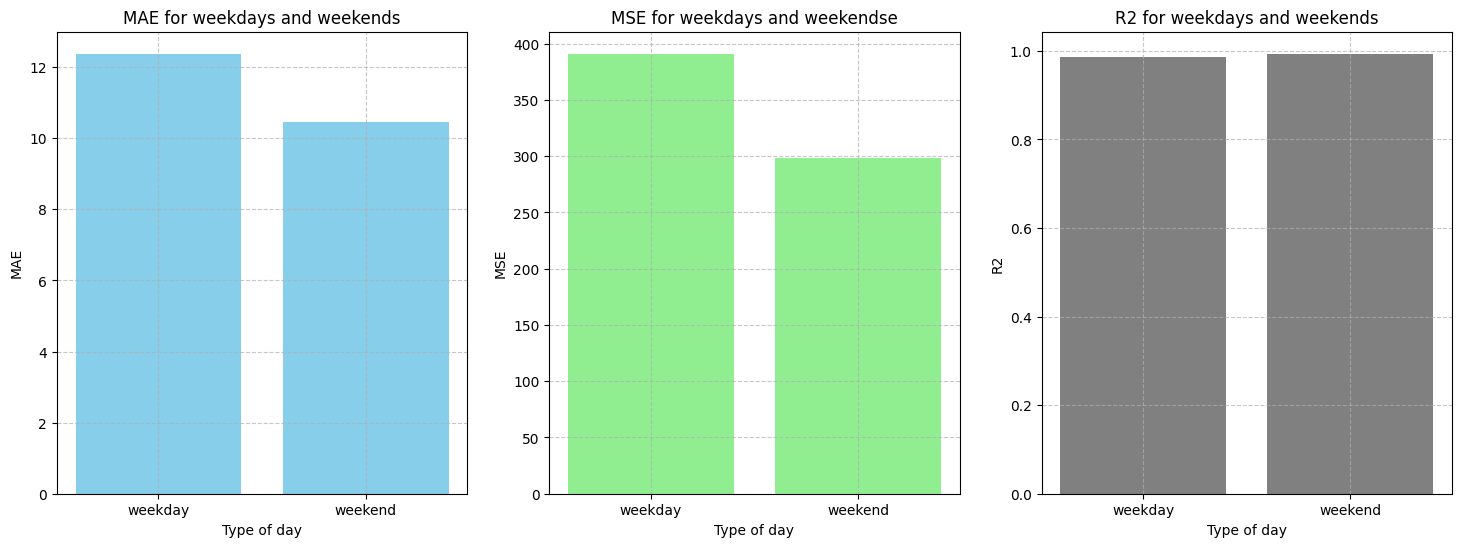

In [8]:
# plotting the performance metrics
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18, 6))

# MAE plot
plt.subplot(1, 3, 1)
plt.bar(['weekday', 'weekend'], [weekday_mae, weekend_mae], color='skyblue')
plt.title('MAE for weekdays and weekends')
plt.xlabel('Type of day')
plt.ylabel('MAE')
plt.grid(True, linestyle='--', alpha=0.7)

# MSE plot
plt.subplot(1, 3, 2)
plt.bar(['weekday', 'weekend'], [weekday_mse, weekend_mse], color='lightgreen')
plt.title('MSE for weekdays and weekendse')
plt.xlabel('Type of day')
plt.ylabel('MSE')
plt.grid(True, linestyle='--', alpha=0.7)

# R2 plot
plt.subplot(1, 3, 3)
plt.bar(['weekday', 'weekend'], [weekday_r2, weekend_r2], color='gray')
plt.title('R2 for weekdays and weekends')
plt.xlabel('Type of day')
plt.ylabel('R2')
plt.grid(True, linestyle='--', alpha=0.7)

# Scenario 2: Evaluating each stop sequence

In [9]:
datasets = {}
mae_list = []
mse_list = []
r2_list = []

# for each stop sequence the corresponding rows are isolated and saved in a dictionary.
# then the model predicts the arrival delays (predictions) on that station
# error scores are calculated based on the prediction

for i in range (1, 28):
  datasets[i] = df[df['stop_sequence'] == i]   # datasets[i] gives the dataset corresponding to stop_sequence i.

  current_dataset = datasets[i]                 # choosing the next dataset

  x = current_dataset.drop(['arrival_delay'], axis=1)
  y = current_dataset['arrival_delay']

  # standardization

  x_c = x[continous]
  x_binary = x[binary]
  x_continous = scaler.transform(x_c)
  x_continous_df = pd.DataFrame(x_continous, columns = continous, index = x.index)
  x_binary = x_binary.reset_index(drop=True)
  x_scaled = pd.concat([x_continous_df.reset_index(drop=True), x_binary], axis = 1)


  predictions = LR_model.predict(x_scaled)
  mae = mean_absolute_error(y, predictions)
  mse = mean_squared_error(y, predictions)
  r2 = r2_score(y, predictions)

  # Save the results
  mae_list.append(mae)
  mse_list.append(mse)
  r2_list.append(r2)


  # print(f"---------- STOP SEQUENCE {i} ----------")
  # print(f"Mean absolute error: {mae}")
  # print(f"Mean squared error: {mse}")
  # print(f"R-squared: {r2}\n")



631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
631/631 ━━━━━━━━

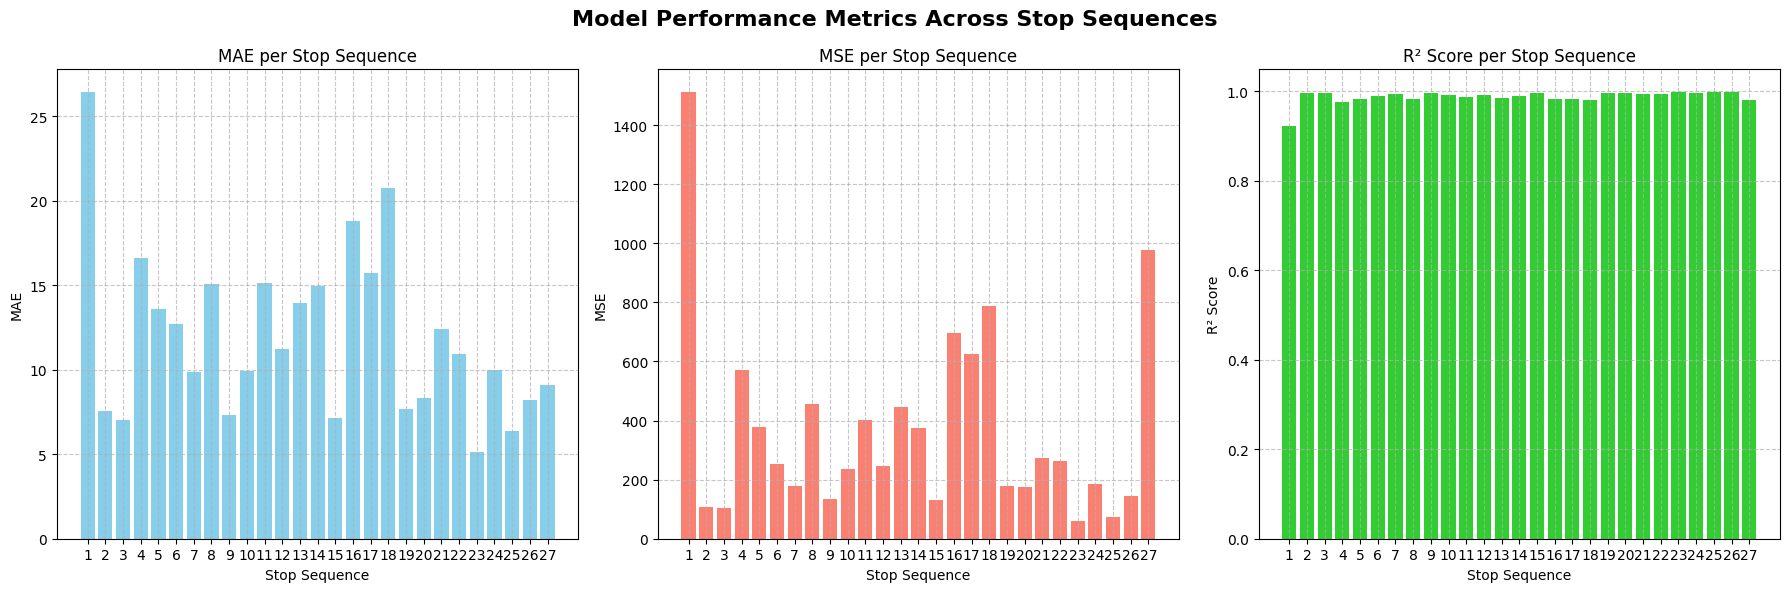

In [10]:
import matplotlib.pyplot as plt
import numpy as np

stop_sequences = np.arange(1, 28)

plt.figure(figsize=(18, 6))

# MAE plot
plt.subplot(1, 3, 1)
plt.bar(stop_sequences, mae_list, color='skyblue')
plt.title('MAE per Stop Sequence')
plt.xlabel('Stop Sequence')
plt.ylabel('MAE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(stop_sequences)

# MSE plot
plt.subplot(1, 3, 2)
plt.bar(stop_sequences, mse_list, color='salmon')
plt.title('MSE per Stop Sequence')
plt.xlabel('Stop Sequence')
plt.ylabel('MSE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(stop_sequences)

# R2 Score plot
plt.subplot(1, 3, 3)
plt.bar(stop_sequences, r2_list, color='limegreen')
plt.title('R² Score per Stop Sequence')
plt.xlabel('Stop Sequence')
plt.ylabel('R² Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(stop_sequences)

# Add styling
plt.suptitle('Model Performance Metrics Across Stop Sequences', fontsize=16, fontweight='bold')
plt.tight_layout()

# Show the plots
plt.show()


In [11]:
  # print(f"Mean absolute error: {mae}")
  # print(f"Mean squared error: {mse}")
  # print(f"R-squared: {r2}\n")
sorted_MAE = sorted(mae_list, reverse=True)
sorted_MSE = sorted(mse_list, reverse=True)
sorted_r2 = sorted(r2_list, reverse=True)

print(sorted_MAE)
print(sorted_MSE)
print(sorted_r2)


[26.46220803434138, 20.756866466519245, 18.790077588546435, 16.633765580530845, 15.733003361166139, 15.163527093781916, 15.102198187610558, 14.981222010031786, 13.941501012644578, 13.605839447181515, 12.738467756021903, 12.396107819052514, 11.258743570206516, 10.926845294480662, 9.97683441006785, 9.90856460836383, 9.890223956801727, 9.075444691676687, 8.341792568604314, 8.202451900311202, 7.683044763563444, 7.574810031096598, 7.346814594632373, 7.1327319412297525, 7.040740869420653, 6.385801300109438, 5.158416645735124]
[1513.1210971007067, 976.7672063746109, 786.5531591407732, 696.9722772418777, 625.8107139651472, 570.9173738142536, 455.46023619757966, 444.7986092719693, 401.8947471426135, 377.13651116188026, 374.51603203089417, 273.55499139817, 262.01893413471487, 253.51857050848082, 245.0009713974111, 237.5875664696667, 185.72640163640705, 180.10881688828024, 179.69159624124103, 173.60483796475737, 145.89615192991982, 132.96087946658406, 130.57512969467328, 109.04876109900799, 105.1